Note: you may need to restart the kernel to use updated packages.


C:\Users\ML\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ML\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ML\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ML\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

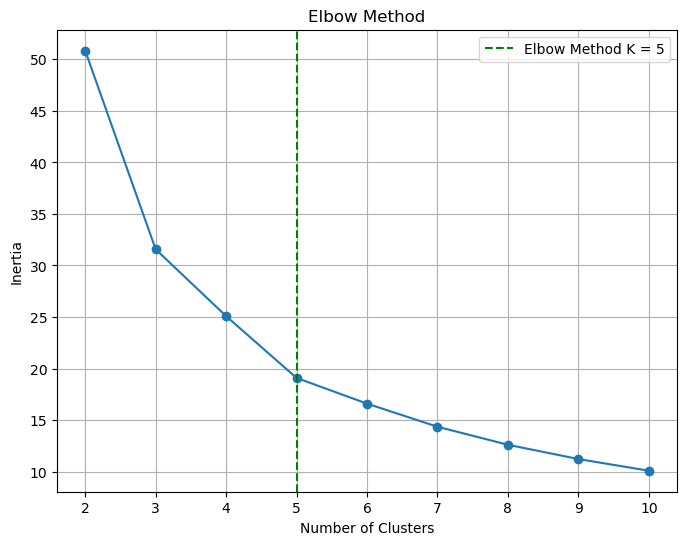

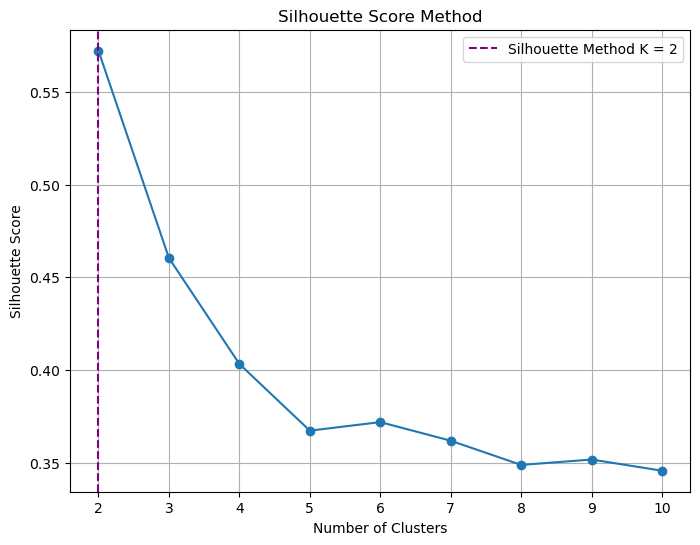

C:\Users\ML\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


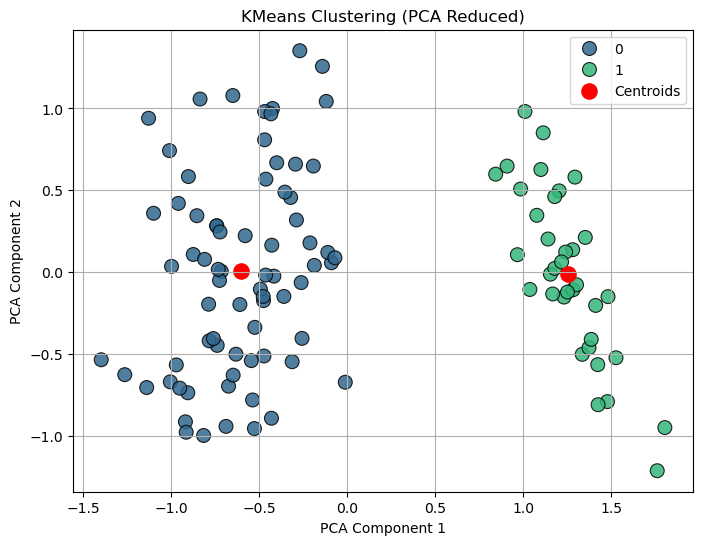

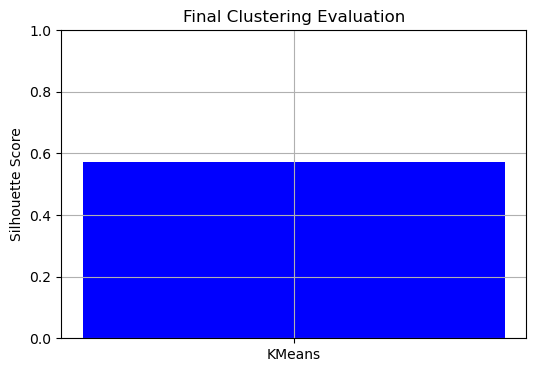

Elbow Method K = 5
Silhouette Method K = 2
Selected Optimal K = 2
Final Silhouette Score = 0.572


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin
from kneed import KneeLocator  
from sklearn.datasets import load_iris


class IntImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill_value_ = round(np.nanmean(X))
        return self
    def transform(self, X):
        return np.nan_to_num(X, nan=self.fill_value_)


def get_preprocessing_pipeline(df):
    float_cols = df.select_dtypes(include=['float64']).columns.tolist()
    int_cols = df.select_dtypes(include=['int64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()

    preprocessor = ColumnTransformer([
        ('float', Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('scaler', RobustScaler())]), float_cols),
        ('int', Pipeline([('imputer', IntImputer()), ('scaler', RobustScaler())]), int_cols),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
    ])
    return preprocessor


def get_optimal_k(X, k_range=(2, 11)):
    inertia, silhouette_scores = [], []
    k_list = range(k_range[0], k_range[1])
   
    for k in k_list:
        model = KMeans(n_clusters=k, random_state=42, n_init=15)
        model.fit(X)
        inertia.append(model.inertia_)
        score = silhouette_score(X, model.labels_) if k >= 2 else -1
        silhouette_scores.append(score)
   
    knee = KneeLocator(k_list, inertia, curve="convex", direction="decreasing")
    elbow_k = knee.elbow
    best_silhouette_k = k_list[silhouette_scores.index(max(silhouette_scores))]
   
    if elbow_k == best_silhouette_k:
        final_k = elbow_k
    else:
        final_k = best_silhouette_k

    return final_k, elbow_k, best_silhouette_k, inertia, silhouette_scores, list(k_list)


def plot_elbow_graph(k_list, inertia, elbow_k):
    plt.figure(figsize=(8, 6))
    plt.plot(k_list, inertia, marker='o')
    plt.axvline(elbow_k, color='green', linestyle='--', label=f'Elbow Method K = {elbow_k}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_silhouette_graph(k_list, silhouette_scores, silhouette_k):
    plt.figure(figsize=(8, 6))
    plt.plot(k_list, silhouette_scores, marker='o')
    plt.axvline(silhouette_k, color='purple', linestyle='--', label=f'Silhouette Method K = {silhouette_k}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Method')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_clusters(X, labels, centers, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='viridis', s=100, edgecolor='k', alpha=0.85)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='o', s=120, label='Centroids')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_final_silhouette_score(score):
    plt.figure(figsize=(6, 4))
    plt.bar(['KMeans'], [score], color='blue')
    plt.ylabel('Silhouette Score')
    plt.title('Final Clustering Evaluation')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()


def run_kmeans_pipeline(df):
    X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
   
    preprocessor = get_preprocessing_pipeline(df)
    X_train_processed = preprocessor.fit_transform(X_train)

    outlier_model = IsolationForest(contamination=0.1, random_state=42)
    outliers = outlier_model.fit_predict(X_train_processed)
    X_train_processed = X_train_processed[outliers == 1]

    k, elbow_k, silhouette_k, inertia, silhouette_scores, k_list = get_optimal_k(X_train_processed)

    plot_elbow_graph(k_list, inertia, elbow_k)
    plot_silhouette_graph(k_list, silhouette_scores, silhouette_k)

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=15)
    labels = kmeans.fit_predict(X_train_processed)
    centers = kmeans.cluster_centers_

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train_processed)
    centers_pca = pca.transform(centers)

    plot_clusters(X_pca, labels, centers_pca, "KMeans Clustering (PCA Reduced)")

    score = silhouette_score(X_train_processed, labels)
    plot_final_silhouette_score(score)

    print(f"Elbow Method K = {elbow_k}")
    print(f"Silhouette Method K = {silhouette_k}")
    print(f"Selected Optimal K = {k}")
    print(f"Final Silhouette Score = {score:.3f}")


iris = load_iris()
df = pd.DataFrame(iris.data)

run_kmeans_pipeline(df)

In [9]:
plot_elbow_graph(k_list, inertia, elbow_k)

NameError: name 'k_list' is not defined